# Lab 05. Cluster analysis



### Сроки сдачи лабы

Дата выдачи: 16.11.2016

Крайняя дата сдачи: 30.11.2016


### О задании

Представим, что международное круизное агентство Carnival Cruise Line решило разрекламировать себя с помощью баннеров. Будет размещено всего 20 баннеров по всему миру. Требуется выбрать 20 таких локаций для размещения, чтобы польза от баннеров была максимальной. Это может быть достигнуто, если баннеры будут размещены вблизи офисов агенства, которые разбросаны по всему миру. Также, необходимо,чтобы эти места были популярны среди туристов, которые потенциально могут воспользоваться услугами агенства.

Для поиска оптимальных мест воспользуемся базой данных социальной сети Foursquare (https://archive.org/details/201309_foursquare_dataset_umn). Исходные данные уже приведены в удобный формат и находятся в файле data.csv. Необходимо кластеризовать координаты мест, помеченных туристами, чтобы выявить центры их скоплений.
 


### Материалы
* [Basemap examples](http://matplotlib.org/basemap/users/examples.html)
* [MeanShift algorithm](http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html)
* [Mapcustomizer](https://www.mapcustomizer.com/)

1. Загрузите данные из data.csv.

2. Всего в файле 396634 строк. На полном объеме данных кластеризация будет работать очень долго. Воспользуйтесь методом data.sample(100000), чтобы выбрать подмножество из 100000 строк для ускорения работы алгоритма кластеризации.

3.  Поскольку баннеры имеют сравнительно небольшую площадь действия, нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров. Воспользуйтесь MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

4. Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

5. Вот адреса офисов компании, близ которых требуется разместить баннеры:

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

6. При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в приведенном выше формате в функцию Bulk Entry на сайте mapcustomizer.com.

7. Определим 20 центров кластеров, ближайших к указанным офисам. Посчитайте дистанцию до ближайшего офиса для каждого центра кластера и выберите 20 с наименьшим значением.

8. Визуализируйте центры кластеров на карте мира при помощи [Basemap](http://matplotlib.org/basemap/users/examples.html).

9. (доп. задание, +2 балла) Выберите другой алгоритм кластеризации на своё усмотрение (http://scikit-learn.org/stable/modules/clustering.html) и сравните результат его работы с MeanShift. Опишите по каким критериям выбрали именно этот алгоритм.

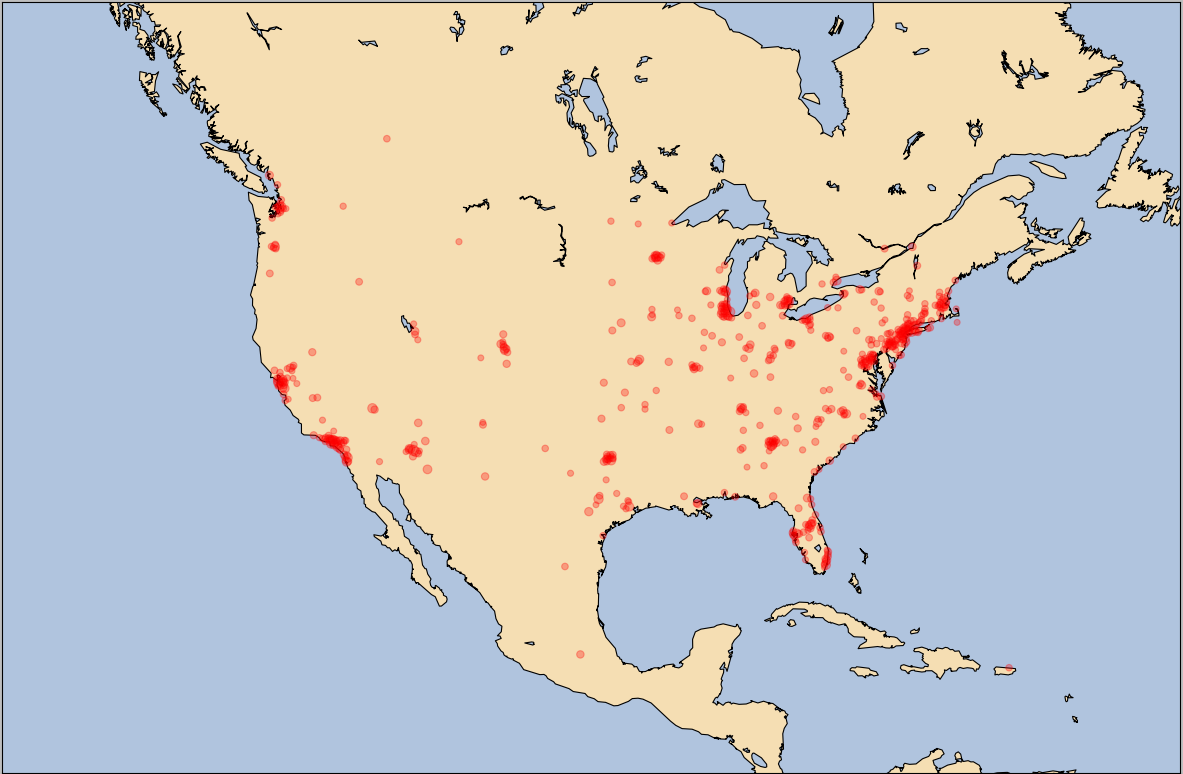

In [2]:
from IPython.display import Image
Image("clusters.png")

# Решение

In [6]:
import pandas as pd
import numpy as np

from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Загрузка данных

In [8]:
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,id,user_id,venue_id,latitude,longitude,created_at
0,1,984222,15824,5222,38.895112,-77.036366,2012-04-21 17:43:47
1,3,984234,44652,5222,33.800745,-84.410520,2012-04-21 17:43:43
2,7,984291,105054,5222,45.523452,-122.676207,2012-04-21 17:39:22
3,9,984318,2146539,5222,40.764462,-111.904565,2012-04-21 17:35:46
4,10,984232,93870,380645,33.448377,-112.074037,2012-04-21 17:38:18


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396634 entries, 0 to 396633
Data columns (total 7 columns):
Unnamed: 0    396634 non-null int64
id            396634 non-null int64
user_id       396634 non-null int64
venue_id      396634 non-null int64
latitude      396634 non-null float64
longitude     396634 non-null float64
created_at    396634 non-null object
dtypes: float64(2), int64(4), object(1)
memory usage: 21.2+ MB


Из основного набора данных сформируем "случайную" подвыборку, с которой будем далее работать.

In [12]:
subsample = data.sample(100000)
subsample.head()

,Unnamed: 0,id,user_id,venue_id,latitude,longitude,created_at
358957,922320,353104,104871,2964,41.088707,-74.013473,2011-12-26 00:08:54
273757,693623,522212,769246,617697,37.629349,-122.400087,2012-01-27 03:59:37
134840,325344,214725,21625,169522,40.733518,-73.780145,2011-12-14 02:01:05
101954,238870,688647,68623,11138,40.014986,-105.270546,2012-03-17 01:23:20
75564,171212,257327,68794,5222,40.014986,-105.270546,2011-12-23 15:32:49


## Построение модели MeanShift

Инициализируем модель, задав необходимые параметры (n_jobs=-1 -- используем процессор на всю мощность).

In [14]:
ms = MeanShift(bandwidth=0.1, n_jobs=-1)

Обучать модель будем на данных, содердащих только географические координаты объектов.

In [16]:
train = subsample[['latitude','longitude']]
train.head()

,latitude,longitude
358957,41.088707,-74.013473
273757,37.629349,-122.400087
134840,40.733518,-73.780145
101954,40.014986,-105.270546
75564,40.014986,-105.270546


In [18]:
%%time
ms.fit(train)

Wall time: 9min 25s


MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=-1, seeds=None)

Посмотрим сколько получилось кластеров

In [21]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("Количество кластеров : %d" % n_clusters_)

Количество кластеров : 3569


## Анализ кластеров

Выделим кластеры, которые содержат более 15 точек. Центры этих кластеров будем в дальнейшем рассматривать как потенциальные точки для размещения баннеров.

In [23]:
from collections import Counter

In [25]:
c = Counter(labels) # Подсчитаем количество точек в кластерах и запишем в виде словаря
main_labels = [key for key, val in c.items() if val > 15] # Селекция кластеров

In [27]:
n_clusters = len(main_labels)
print("Количество 'хороших' кластеров: %d" % n_clusters)

Количество 'хороших' кластеров: 615


Выбираем среди всех всех центров кластеров только те, которые принадлежат "хорошим" кластерам (т.е. содержат более 15 точек). Хранить центры кластеров будем в виде словаря (ключ -- метка кластера, значение -- координаты центра кластера).

In [29]:
clusters = {}
for i, label in enumerate(labels_unique):
    if label in main_labels:
        clusters[label] = cluster_centers[i]

In [31]:
n_clusters = len(clusters)
print(n_clusters)

615


### Локация офисов компаний

Изобразим на карте географичиские координаты офисов компаний.

In [ ]:
%matplotlib inline

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

In [33]:
locations = np.asfarray([[33.751277, -118.188740], [25.867736, -80.324116], [51.503016, -0.075479],
                    [52.378894, 4.885084], [39.366487, 117.036146], [-33.868457, 151.205134]])

In [204]:
def map(locations, size=200, marker='v', color='b', title='Location of companies'):
    plt.figure(figsize=(20, 15), dpi=200, facecolor='w')
    lons = locations[:, 1]
    lats = locations[:, 0]

    m = Basemap(projection='robin', lon_0=0)
    # compute map projection coordinates for lat/lon grid.
    x, y = m(lons,lats)
    # make filled contour plot.
    m.drawcoastlines() # draw coastlines
    m.drawmapboundary() # draw a line around the map region
    m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0]) # draw parallels
    m.drawmeridians(np.arange(0.,420.,60.),labels=[0,0,0,1]) # draw meridians
    plt.title(title) # add a title
    m.scatter(x,y,size,marker=marker,color=color)
    plt.show()

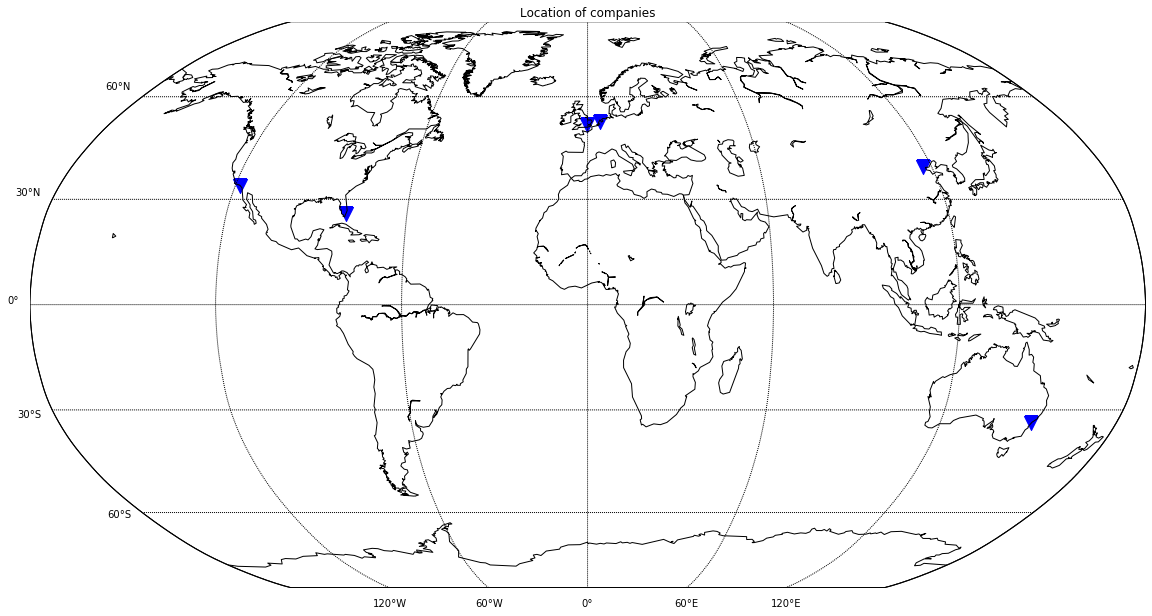

In [202]:
map(locations)

## "Горячие" точки

Определим 20 центров кластеров, которые расположены ближе всего к указанным выше офисам компаний.

In [36]:
from scipy.spatial.distance import euclidean

In [197]:
def hot_points(comp_locs, clusters):
    hp = []
    for c_loc in comp_locs:
        for loc in clusters.values():
            dist = euclidean(c_loc, loc)
            hp.append((dist, loc))
    hp = sorted(hp)[:20]
    lons = [x[0] for dist,x in hp]
    lats = [x[1] for dist,x in hp]
    return lons, lats
    #return [x for dist,x in hp]

Отметим местоположения баннеров на карте

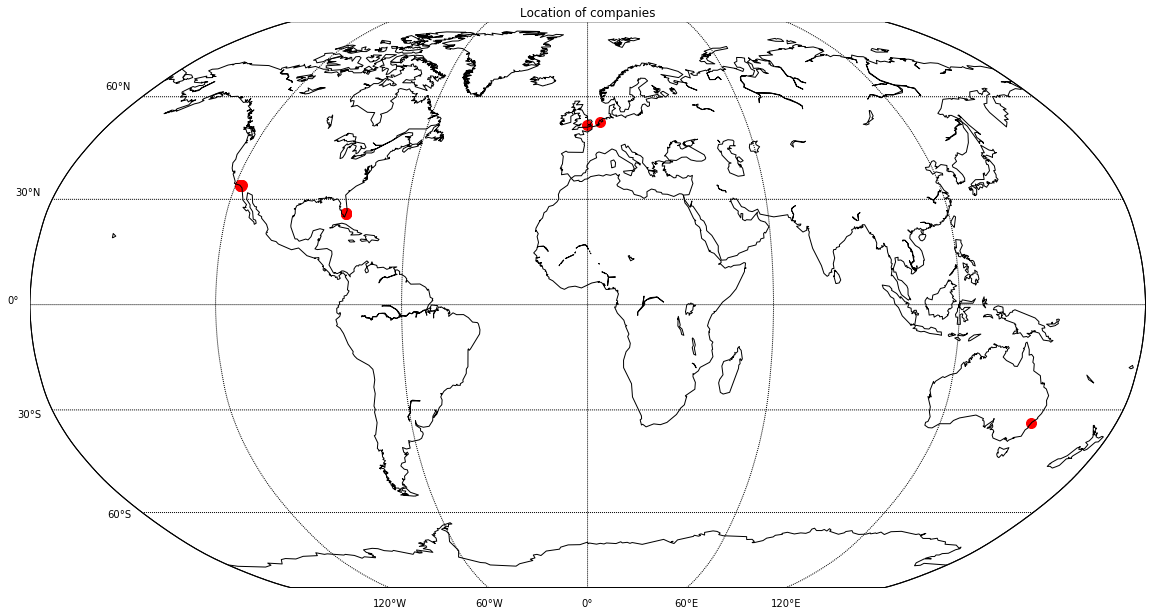

In [205]:
locs = np.transpose(np.array(hot_points(locations, clusters))) # Location of banners
map(locs, size=100, marker='o', color='r')

Видно, что точки тесно "кучкуются" возле офисов компаний. Более детально посмотрим что происходит, например, возле офиса солнечном Майами.

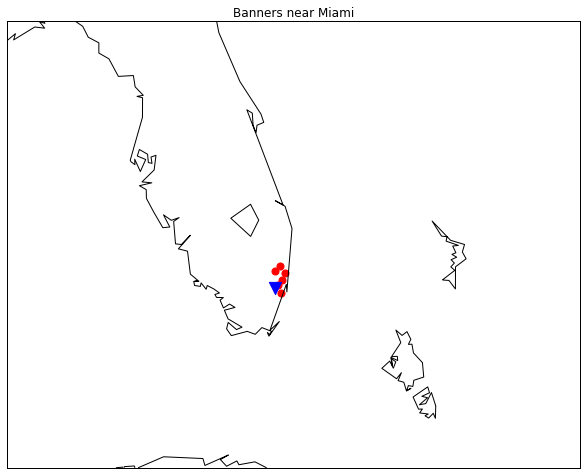

In [231]:
c_lats, c_lons = hot_points(locations, clusters)
llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat = (-85, 23, -75, 30)

lons = locations[:, 1]
lats = locations[:, 0]

plt.figure(figsize=(12, 8), dpi=200, facecolor='w')
m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
# compute map projection coordinates for lat/lon grid.
c_x, c_y = m(c_lons,c_lats)
x, y = m(lons,lats)
# make filled contour plot.
m.drawcoastlines() # draw coastlines
m.drawmapboundary() # draw a line around the map region
m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0]) # draw parallels
m.drawmeridians(np.arange(0.,420.,60.),labels=[0,0,0,1]) # draw meridians
plt.title('Banners near Miami') # add a title
m.scatter(c_x,c_y,50,marker='o',color='r')
m.scatter(x,y,150,marker='v',color='b')
plt.show()

## **Бонус. Построение альтернативной модели

Для сравнения с MeanShift рассмотрим алгоритм [DBSCAN](http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py).

In [232]:
from sklearn.cluster import DBSCAN

In [ ]:
db = DBSCAN()